In [2]:
# import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

# import matplotlib for plotting
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# import helper libraries
import requests
from io import BytesIO # Use When expecting bytes-like objects
import pickle
from collections import OrderedDict
import os
from os import path
import time
import argparse

# import PIL for image manipulation
from PIL import Image

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# import pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import sys
sys.path.append("../src/")
import image_utils
from image_utils import add_flipped_and_rotated_images
from simple_conv_nn import SimpleCNN

In [3]:
def load_data():
    print("Loading data \n")

    # Check for already loaded datasets
    if not(path.exists('xtrain_doodle.pickle')):
        # Load from web
        print("Loading data from the web \n")

        # Classes we will load
        categories = ['bee', 'cat', 'cow', 'dog', 'duck', 'horse', 'pig', 'rabbit', 'snake', 'whale']

        # Dictionary for URL and class labels
        URL_DATA = {}
        for category in categories:
            URL_DATA[category] = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/' + category +'.npy'

        # Load data for classes in dictionary
        classes_dict = {}
        for key, value in URL_DATA.items():
            response = requests.get(value)
            classes_dict[key] = np.load(BytesIO(response.content))

        # Generate labels and add labels to loaded data
        for i, (key, value) in enumerate(classes_dict.items()):
            value = value.astype('float32')/255.
            if i == 0:
                classes_dict[key] = np.c_[value, np.zeros(len(value))]
            else:
                classes_dict[key] = np.c_[value,i*np.ones(len(value))]

        # Create a dict with label codes
        label_dict = {0:'bee', 1:'cat', 2:'cow', 3:'dog', 4:'duck',
                      5:'horse', 6:'pig', 7:'rabbit', 8:'snake', 9:'whale'}

        lst = []
        for key, value in classes_dict.items():
            lst.append(value[:3000])
        doodles = np.concatenate(lst)

        # Split the data into features and class labels (X & y respectively)
        y = doodles[:,-1].astype('float32')
        X = doodles[:,:784]

        # Split each dataset into train/test splits
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)
    else:
        # Load data from pickle files
        print("Loading data from pickle files \n")

        file = open("xtrain_doodle.pickle",'rb')
        X_train = pickle.load(file)
        file.close()

        file = open("xtest_doodle.pickle",'rb')
        X_test = pickle.load(file)
        file.close()

        file = open("ytrain_doodle.pickle",'rb')
        y_train = pickle.load(file)
        file.close()

        file = open("ytest_doodle.pickle",'rb')
        y_test = pickle.load(file)
        file.close()

    return X_train, y_train, X_test, y_test, classes_dict

In [4]:
categories = ['bee', 'cat', 'cow', 'dog', 'duck', 'horse', 'pig', 'rabbit', 'snake', 'whale']

URL_DATA = {}
for category in categories:
    URL_DATA[category] = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/' + category +'.npy'

URL_DATA

{'bee': 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bee.npy',
 'cat': 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy',
 'cow': 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cow.npy',
 'dog': 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy',
 'duck': 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/duck.npy',
 'horse': 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/horse.npy',
 'pig': 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pig.npy',
 'rabbit': 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rabbit.npy',
 'snake': 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/snake.npy',
 'whale': 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/whale.npy'}

In [5]:
classes_dict = {}
for key, value in URL_DATA.items():
    response = requests.get(value)
    classes_dict[key] = np.load(BytesIO(response.content))

In [6]:
classes_dict

{'bee': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'cat': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'cow': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'dog': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'duck': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0

In [7]:
len(classes_dict['dog'])

152159

In [8]:
len(classes_dict['cat'])

123202

In [9]:
# Generate labels and add labels to loaded data
for i, (key, value) in enumerate(classes_dict.items()):
    value = value.astype('float32')/255.
    if i == 0:
        classes_dict[key] = np.c_[value, np.zeros(len(value))]
    else:
        classes_dict[key] = np.c_[value,i*np.ones(len(value))]

In [10]:
classes_dict['bee']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
classes_dict['bee'][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.21568628, 0.33725491,
       0.40000001, 0.40000001, 0.21960784, 0.        , 0.     

In [12]:
label_dict = {0:'bee', 1:'cat', 2:'cow', 3:'dog', 4:'duck',
              5:'horse', 6:'pig', 7:'rabbit', 8:'snake', 9:'whale'}

lst = []
for key, value in classes_dict.items():
    lst.append(value[:50000])
doodles = np.concatenate(lst)

In [13]:
len(doodles)

500000

In [14]:
doodles[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.21568628, 0.33725491,
       0.40000001, 0.40000001, 0.21960784, 0.        , 0.     

In [15]:
y = doodles[:,-1].astype('float32')
X = doodles[:,:784]

In [16]:
y

array([0., 0., 0., ..., 9., 9., 9.], dtype=float32)

In [17]:
len(y)

500000

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
len(X_train)

350000

In [37]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [58]:
len(X_train[0])

784

In [39]:
X_train[0][0]

0.0

In [40]:
X_train[0][1]

0.0

In [41]:
len(y_train)

350000

In [21]:
def save_data(X_train, y_train, X_test, y_test, force = False):
    
    # Check for already saved files
    if not(path.exists('../data/xtrain.pickle')) or force:
        # Save X_train dataset as a pickle file
        with open('../data/xtrain.pickle', 'wb') as f:
            pickle.dump(X_train, f)

        # Save X_test dataset as a pickle file
        with open('../data/xtest.pickle', 'wb') as f:
            pickle.dump(X_test, f)

        # Save y_train dataset as a pickle file
        with open('../data/ytrain.pickle', 'wb') as f:
            pickle.dump(y_train, f)

        # Save y_test dataset as a pickle file
        with open('../data/ytest.pickle', 'wb') as f:
            pickle.dump(y_test, f)

In [22]:
save_data(X_train, y_train, X_test, y_test)

In [23]:
type(X_train)

numpy.ndarray

In [24]:
type(X_test)

numpy.ndarray

In [25]:
type(y_train)

numpy.ndarray

In [26]:
len(X_train)

350000

In [46]:
len(X_test)

150000

In [27]:
def build_model_rnn(input_size, output_size, dropout = 0.0):
    model = nn.Sequential(OrderedDict([
                         ('fc1', nn.Linear(input_size, 128)),
                         ('relu1', nn.ReLU()),
                         ('fc2', nn.Linear(128, 100)),
                         ('bn2', nn.BatchNorm1d(num_features=100)),
                         ('relu2', nn.ReLU()),
                         ('dropout', nn.Dropout(dropout)),
                         ('fc3', nn.Linear(100, 64)),
                         ('bn3', nn.BatchNorm1d(num_features=64)),
                         ('relu3', nn.ReLU()),
                         ('logits', nn.Linear(64, output_size))]))
    return model

In [28]:
rnn_model = build_model_rnn(input_size=784, output_size=10)

In [29]:
rnn_model   

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (fc3): Linear(in_features=100, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (logits): Linear(in_features=64, out_features=10, bias=True)
)

In [50]:
cnn_model = build_model(input_size = 784, output_size=10, architecture='conv')

In [51]:
cnn_model

SimpleCNN(
  (conv1): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3528, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [61]:
X_train = pickle.load(open('data/xtrain.pickle', 'rb'))
X_test = pickle.load(open('data/xtest.pickle', 'rb'))
y_train = pickle.load(open('data/ytrain.pickle', 'rb'))
y_test = pickle.load(open('data/ytest.pickle', 'rb'))

In [71]:
from sklearn.utils import shuffle

In [72]:
def shuffle_dataset(X_train, y_train):
    
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
    y_train_shuffled = y_train_shuffled.reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled

In [73]:
X_train_shuffled, y_train_shuffled = shuffle_dataset(X_train, y_train)

In [74]:
X_train_shuffled[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0118, 0.2667, 0.4431, 0.1294, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2706, 0.9020, 1.0000, 1.0000, 0.7725, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.3216, 0.6902, 0.5451, 0.0824, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4392, 0.9882, 0.8000, 0.2902, 0.4392, 1.0000, 0.1333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [75]:
type(X_train_shuffled)

torch.Tensor

In [76]:
type(y_train_shuffled)

torch.Tensor

In [77]:
y_train_numpy = y_train_shuffled.numpy()

In [78]:
type(y_train_numpy)

numpy.ndarray

In [79]:
def fit_model(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0, optimizer = 'SGD'):

    print("Fitting model with epochs = {epochs}, learning rate = {lr}\n"\
    .format(epochs = epochs, lr = learning_rate))
    criterion = nn.CrossEntropyLoss()
    if (optimizer == 'SGD'):
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    print_every = 100
    steps = 0
    for e in range(epochs):
        running_loss = 0
        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)
        for i in range(n_chunks):
            steps += 1
            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if steps % print_every == 0:
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))
                running_loss = 0


In [80]:
fit_model(rnn_model, X_train_shuffled, y_train_shuffled)

Fitting model with epochs = 100, learning rate = 0.003

Epoch: 1/100...  Loss: 2.2500
Epoch: 1/100...  Loss: 2.0532
Epoch: 1/100...  Loss: 1.9560
Epoch: 1/100...  Loss: 1.9172
Epoch: 1/100...  Loss: 1.8319
Epoch: 1/100...  Loss: 1.7964
Epoch: 1/100...  Loss: 1.7501
Epoch: 1/100...  Loss: 1.7265
Epoch: 1/100...  Loss: 1.7047
Epoch: 1/100...  Loss: 1.6432
Epoch: 2/100...  Loss: 1.5954
Epoch: 2/100...  Loss: 1.5887
Epoch: 2/100...  Loss: 1.5604
Epoch: 2/100...  Loss: 1.5827
Epoch: 2/100...  Loss: 1.5197
Epoch: 2/100...  Loss: 1.5310
Epoch: 2/100...  Loss: 1.5061
Epoch: 2/100...  Loss: 1.5030
Epoch: 2/100...  Loss: 1.5110
Epoch: 2/100...  Loss: 1.4452
Epoch: 3/100...  Loss: 1.4268
Epoch: 3/100...  Loss: 1.4248
Epoch: 3/100...  Loss: 1.4078
Epoch: 3/100...  Loss: 1.4383
Epoch: 3/100...  Loss: 1.3877
Epoch: 3/100...  Loss: 1.4022
Epoch: 3/100...  Loss: 1.3766
Epoch: 3/100...  Loss: 1.3779
Epoch: 3/100...  Loss: 1.3853
Epoch: 3/100...  Loss: 1.3242
Epoch: 4/100...  Loss: 1.3144
Epoch: 4/100..

In [82]:
def save_model(model, architecture, input_size, output_size, dropout, filepath = 'checkpoint.pth'):
    print("Saving model to {}\n".format(filepath))
    if architecture == 'nn':
        checkpoint = {'input_size': input_size,
                  'output_size': output_size,
                  'dropout': dropout,
                  'state_dict': model.state_dict()}

        torch.save(checkpoint, filepath)
    else:
        checkpoint = {'state_dict': model.state_dict()}
        torch.save(checkpoint, filepath)

In [83]:
save_model(rnn_model, 'nn', 784, 10, 0.0, 'checkpoint.pth')

Saving model to checkpoint.pth



In [86]:
def load_model(architecture = 'nn', filepath = 'checkpoint.pth'):
    print("Loading model from {} \n".format(filepath))

    if architecture == 'nn':
        checkpoint = torch.load(filepath)
        input_size = checkpoint['input_size']
        output_size = checkpoint['output_size']
        dropout = checkpoint['dropout']
        model = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(input_size, 128)),
                              ('relu1', nn.ReLU()),
                              ('fc2', nn.Linear(128, 100)),
                              ('bn2', nn.BatchNorm1d(num_features=100)),
                              ('relu2', nn.ReLU()),
                              ('dropout', nn.Dropout(dropout)),
                              ('fc3', nn.Linear(100, 64)),
                              ('bn3', nn.BatchNorm1d(num_features=64)),
                              ('relu3', nn.ReLU()),
                              ('logits', nn.Linear(64, output_size))]))
        model.load_state_dict(checkpoint['state_dict'])

    else:
        checkpoint = torch.load(filepath)
        model = SimpleCNN()
        model.load_state_dict(checkpoint['state_dict'])

    return model

In [87]:
model = load_model(architecture = 'nn', filepath = 'checkpoint.pth')

Loading model from checkpoint.pth 



In [123]:
def get_preds(model, input, architecture = 'nn'):
    # Turn off gradients to speed up this part
    with torch.no_grad():
        if architecture == 'nn':
            logits = model.forward(input)
        else:
            # image = input.numpy()
            image = input.reshape(input.shape[0], 1, 28, 28)
            logits = model.forward(torch.from_numpy(image).float())

    ps = F.softmax(logits, dim=1)
    return ps

In [89]:
def evaluate_model(model, train, y_train, test, y_test, architecture = 'nn'):
    train_pred = get_preds(model, train, architecture)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test, architecture)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {} \n".format(accuracy_train))
    print("Accuracy score for test set is {} \n".format(accuracy_test))

    return accuracy_train, accuracy_test

In [90]:
def get_labels(pred):
    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels

In [91]:
y_test = y_test.reshape((X_test.shape[0], 1))
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [92]:
y_test_numpy = y_test.numpy()

In [93]:
evaluate_model(model, X_train_shuffled, y_train_shuffled, X_test, y_test, architecture='nn')

Accuracy score for train set is 0.9446190476190476 

Accuracy score for test set is 0.5308888888888889 



(0.9446190476190476, 0.5308888888888889)

In [94]:
evaluate_model

<function __main__.evaluate_model(model, train, y_train, test, y_test, architecture='nn')>

In [95]:
def plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate = 0.003, weight_decay = 0.0, dropout = 0.0, n_chunks = 1000, optimizer = 'SGD'):
    """
    Function to plot learning curve depending on the number of epochs.

    INPUT:
        input_size, output_size, hidden_sizes - model parameters
        train - (tensor) train dataset
        labels - (tensor) labels for train dataset
        y_train - (numpy) labels for train dataset
        test - (tensor) test dataset
        y_test - (numpy) labels for test dataset
        learning_rate - learning rate hyperparameter
        weight_decay - weight decay (regularization)
        dropout - dropout for hidden layer
        n_chunks - the number of minibatches to train the model
        optimizer - optimizer to be used for training (SGD or Adam)

    OUTPUT: None
    """
    train_acc = []
    test_acc = []

    for epochs in np.arange(10, 210, 10):
        # create model
        modle = build_model(input_size, output_size, hidden_sizes, dropout = dropout)

        # fit model
        fit_model(modle, train, labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay, optimizer = optimizer)
        # get accuracy
        accuracy_train, accuracy_test = evaluate_model(modle, train, y_train, test, y_test)

        train_acc.append(accuracy_train)
        test_acc.append(accuracy_test)

    # Plot curve
    x = np.arange(10, 210, 10)
    plt.plot(x, train_acc)
    plt.plot(x, test_acc)
    plt.legend(['train', 'test'], loc='upper left')
    plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=20)
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)

    ts = time.time()
    plt.savefig('learning_curve' + str(ts) + '.png')

    df = pd.DataFrame.from_dict({'train' : train_acc, 'test' :test_acc})
    df.to_csv('learning_curve_' + str(ts) + '.csv')

In [96]:
plot_learning_curve(input_size=784, output_size=10, hidden_sizes=[128, 100, 64], 
                    train=X_train_shuffled, labels=y_train_shuffled, 
                    y_train=y_train_numpy, 
                    test=X_test, y_test=y_test)

UnboundLocalError: local variable 'model' referenced before assignment

In [97]:
X_train[0].shape

(784,)

In [98]:
def view_image(img, filename = 'image'):
    fig, ax = plt.subplots(figsize=(6,9))
    ax.imshow(img.reshape(28, 28).squeeze())
    ax.axis('off')
    plt.savefig(filename + '.png')

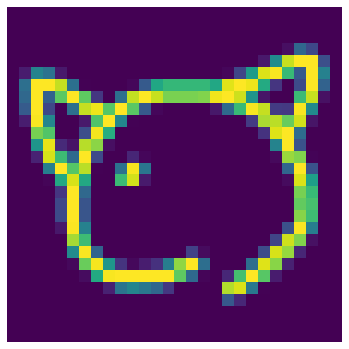

In [99]:
view_image(X_train[0], filename='train_0')

In [100]:
def fit_conv(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0, optimizer = 'SGD'):

    print("Fitting model with epochs = {epochs}, learning rate = {lr}\n"\
    .format(epochs = epochs, lr = learning_rate))

    criterion = nn.CrossEntropyLoss()

    if (optimizer == 'SGD'):
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    print_every = 100
    steps = 0

    for e in range(epochs):
        running_loss = 0
        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(n_chunks):
            steps += 1
            optimizer.zero_grad()

            # Forward and backward passes
            np_images = images[i].numpy()
            np_images = np_images.reshape(images[i].shape[0], 1, 28, 28)
            img = torch.from_numpy(np_images).float()

            output = model.forward(img)
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))

                running_loss = 0

In [101]:
X_train_shuffled_numpy = X_train_shuffled.numpy()
y_train_shuffled_numpy = y_train_shuffled.numpy()

In [102]:
fit_conv(cnn_model, X_train_shuffled, y_train_shuffled, optimizer='Adam')

Fitting model with epochs = 100, learning rate = 0.003

Epoch: 1/100...  Loss: 1.8543
Epoch: 1/100...  Loss: 1.5091
Epoch: 1/100...  Loss: 1.3295
Epoch: 1/100...  Loss: 1.2844
Epoch: 1/100...  Loss: 1.1564
Epoch: 1/100...  Loss: 1.1527
Epoch: 1/100...  Loss: 1.0981
Epoch: 1/100...  Loss: 1.1087
Epoch: 1/100...  Loss: 1.0981
Epoch: 1/100...  Loss: 1.0373
Epoch: 2/100...  Loss: 1.0123
Epoch: 2/100...  Loss: 0.9992
Epoch: 2/100...  Loss: 0.9579
Epoch: 2/100...  Loss: 0.9751
Epoch: 2/100...  Loss: 0.9313
Epoch: 2/100...  Loss: 0.9367
Epoch: 2/100...  Loss: 0.9022
Epoch: 2/100...  Loss: 0.9105
Epoch: 2/100...  Loss: 0.9232
Epoch: 2/100...  Loss: 0.8795
Epoch: 3/100...  Loss: 0.8707
Epoch: 3/100...  Loss: 0.8727
Epoch: 3/100...  Loss: 0.8319
Epoch: 3/100...  Loss: 0.8449
Epoch: 3/100...  Loss: 0.8190
Epoch: 3/100...  Loss: 0.8216
Epoch: 3/100...  Loss: 0.7981
Epoch: 3/100...  Loss: 0.7970
Epoch: 3/100...  Loss: 0.8114
Epoch: 3/100...  Loss: 0.7729
Epoch: 4/100...  Loss: 0.7799
Epoch: 4/100..

In [117]:
type(X_train_shuffled)

torch.Tensor

In [119]:
type(X_test)

torch.Tensor

In [120]:
type(y_train_shuffled)

torch.Tensor

In [121]:
type(y_test)

torch.Tensor

In [125]:
X_test_numpy = X_test.numpy()

In [126]:
evaluate_model(cnn_model, X_train_shuffled_numpy, y_train_shuffled_numpy, X_test_numpy, y_test_numpy, architecture="conv")

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'